# Kalman Filter 활용 pair trading
---
- 선형 동적 모형에 대한 필터링 문제와 스무딩 문제를 푸는 방법
- 확률 변수의 분포를 갱신하는 베이지안 필터의 한 종류
- 가우시안 분포를 가지는 선형 시스템이라는 제약 조건을 사용하여 상태 변수의 평균과 분산을 간단히 갱신하는 효율적 알고리즘
- Kalman Filter 관측 방적식을 통해 2개의 주가의 spread를 분석

In [37]:
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import statsmodels
import statsmodels.api as sm

In [38]:
data1= pdr.get_data_yahoo('055550.KS').reset_index() # 신한지주
df1 = data1[['Date','Close']]
df1.columns = ['Date','corp1']

data2 = pdr.get_data_yahoo('024110.KS').reset_index() # 기업은행
df2 = data2[['Date','Close']]
df2.columns = ['Date','corp2']


tickers = ['corp1','corp2']

In [39]:
df1.set_index('Date', inplace=True)
df2.set_index('Date', inplace=True)

data_all = pd.concat([df1, df2], axis=1)
# data_all

<AxesSubplot:xlabel='Date'>

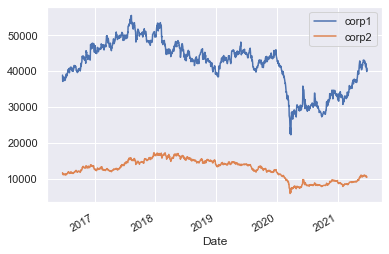

In [40]:
# plt.plot(kko['Close'], label='kko')
# plt.plot(nav['Close'], label='nav')
data_all.plot()
# data_all['corp2'].plot()

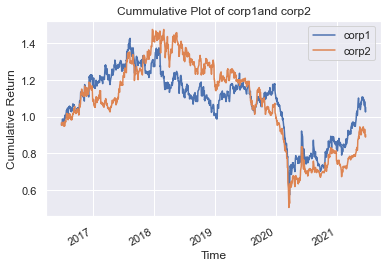

In [41]:
cumm_rtn = (1 + data_all.pct_change()).cumprod()  # 일일수익률 누적곱
cumm_rtn.plot();
plt.ylabel('Cumulative Return');
plt.xlabel('Time');
title = 'Cummulative Plot of ' + tickers[0] + 'and ' + tickers[1]
plt.title(title);

In [42]:
# colors = np.linspace(0.1, 1, len(data_all))
# sc = plt.scatter(data_all[tickers[0]], data_all[tickers[1]], s=30,
#                  c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
# cb = plt.colorbar(sc)
# cb.ax.set_yticklabels([p for p in data_all[::len(data_all)//9].index])
# plt.xlabel(tickers[0])
# plt.ylabel(tickers[1])

In [43]:
# data = data_all

In [44]:
# x = sm.add_constant(data[tickers[0]], prepend=False)
# ols = sm.OLS(data[tickers[1]], x).fit()
# beta = ols.params
# y_fit = [x.min().dot(beta), x.max().dot(beta)]

In [45]:
# print(ols.summary2())

In [46]:
# colors = np.linspace(0.1, 1, len(data))
# sc = plt.scatter(data[tickers[0]], data[tickers[1]], s=30, 
#                  c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
# plt.plot([x.min()[0], x.max()[0]], y_fit, '--b', linewidth=3, label='Linear Regression Fit')
# plt.legend()

# cb = plt.colorbar(sc)
# cb.ax.set_yticklabels([str(p.date()) for p in data[::len(data)//9].index])
# plt.xlabel(tickers[0])
# plt.ylabel(tickers[1]);

In [47]:
# spread = pd.DataFrame(data[tickers[1]] - beta[0] * data[tickers[0]] - beta[1])
# spread.columns = ['in-sample']

In [48]:
# spread.plot();
# plt.xlabel('Time');
# plt.ylabel('Spread');
# plt.title('corp1 - corp2 Spread')

In [49]:
# adf = statsmodels.tsa.stattools.adfuller(spread['in-sample'], maxlag=1)
# print('ADF test statistic: ',adf[0])
# print('p-value: ',adf[1])

In [50]:
# spread.plot();
# plt.axhline(spread['in-sample'].mean(), ls = '--', color='b');
# plt.axhline(spread['in-sample'].mean() + spread['in-sample'].std(), ls = '--', color='y');
# plt.axhline(spread['in-sample'].mean() - spread['in-sample'].std(), ls = '--', color='y');

### kalman Filter

In [51]:
obs_mat = sm.add_constant(data_all[tickers[0]].values, prepend=False)[:, np.newaxis]
delta = 1e-5
trans_cov = delta / (1 - delta) * np.eye(2)

# y is 1-dimensional, (alpha, beta) is 2-dimensional
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  initial_state_mean=np.zeros(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=1.0,
                  transition_covariance=trans_cov)

In [52]:
state_means, state_covs = kf.filter(data_all[tickers[1]])


In [53]:
beta_kf = pd.DataFrame({'Slope': state_means[:, 0], 'Intercept': state_means[:, 1]},
                       index=data_all.index)

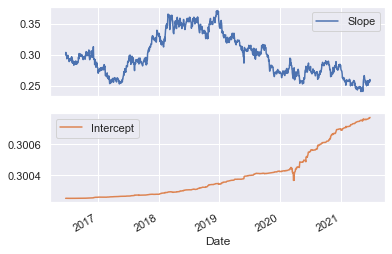

In [54]:
beta_kf.plot(subplots=True);

<ipython-input-55-7ffe99ef9db2>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([p for p in data_all[::len(data_all)//9].index]); # [str(p.date())


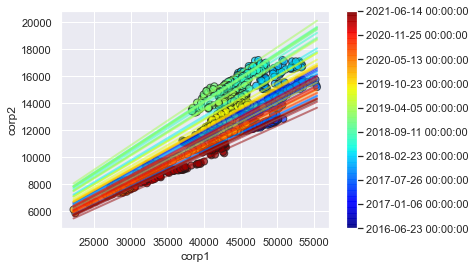

In [55]:
# visualize the correlation between assest prices over time
dates = [p for p in data_all[::int(len(data_all)/10)].index] # str(p.date())
colors = np.linspace(0.1, 1, len(data_all))
sc = plt.scatter(data_all[tickers[0]], data_all[tickers[1]],
                 s=50, c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([p for p in data_all[::len(data_all)//9].index]); # [str(p.date())
plt.xlabel(tickers[0])
plt.ylabel(tickers[1])

# add regression lines
step = 25
xi = np.linspace(data_all[tickers[0]].min(), data_all[tickers[0]].max(), 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, b in enumerate(state_means[::step]):
    plt.plot(xi, b[0] * xi + b[1], alpha=.5, lw=2, c=plt.get_cmap('jet')(colors_l[i]))

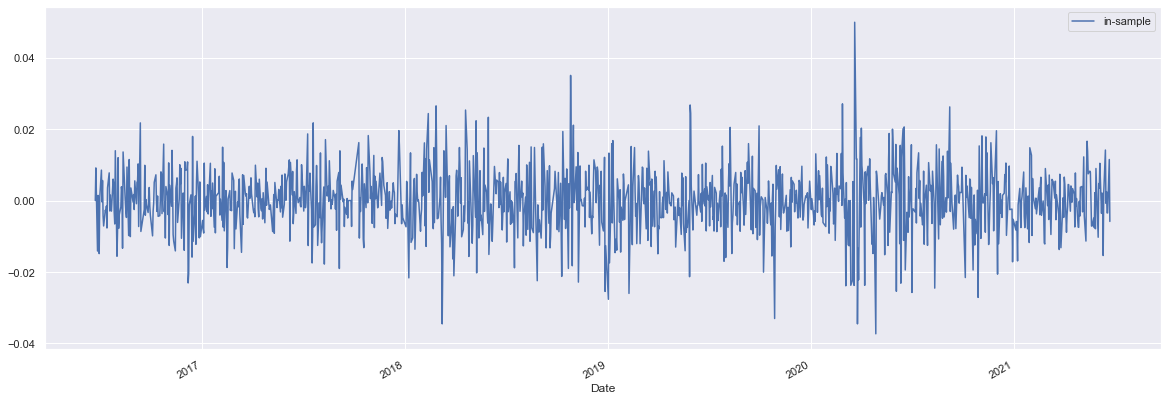

In [56]:
spread_kf = pd.DataFrame(data_all[tickers[1]] - data_all[tickers[0]] * beta_kf['Slope'] - beta_kf['Intercept'])
spread_kf.columns = ['in-sample']
spread_kf.plot(figsize=(20,7));


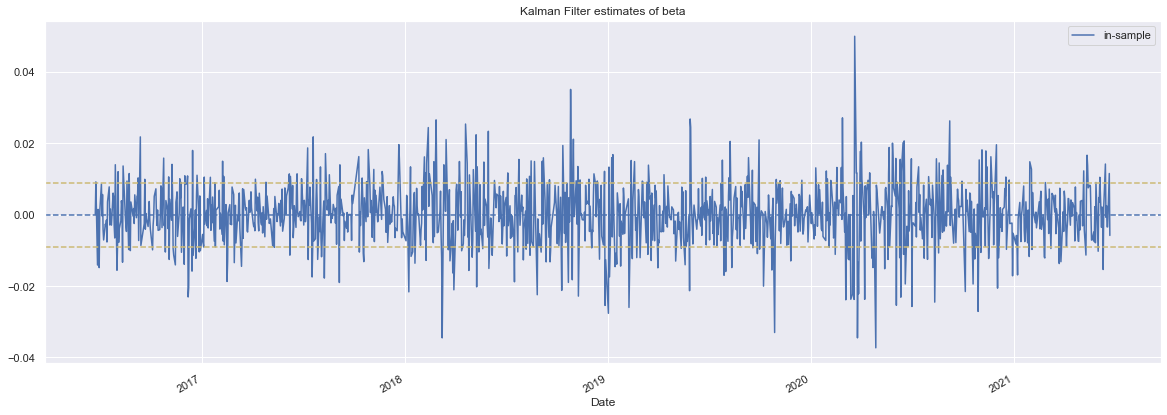

In [57]:
spread_kf.plot(figsize=(20,7))
plt.axhline(spread_kf['in-sample'].mean(), ls = '--', color='b');
plt.axhline(spread_kf['in-sample'].mean() + spread_kf['in-sample'].std(), ls = '--', color='y');
plt.axhline(spread_kf['in-sample'].mean() - spread_kf['in-sample'].std(), ls = '--', color='y');
plt.legend(loc=0);

plt.title('Kalman Filter estimates of beta');

# 공적분 활용 pair trading
---
- 주식 한 쌍이 일시적인 격차가 벌어지거나 좁혀졌을때, 시간에 따라 정상으로 회귀할 것으로 예측 될때 사용
> 실제 비대칭적 주식시장에는 맞지 않음
- Z-score가 -1이하로 떨어지면 S1매수&S2매도하고 +1이상 오르면 S1매도&S2매수
- 아래와 같은 요소들에 의해 매도/매수 신호를 포착
> - 60 day Moving Average of Ratio: Measure of rolling mean
> - 5 day Moving Average of Ratio: Measure of current value of mean
> - 60 day Standard Deviation
> - z score: (5d MA — 60d MA) /60d SD

In [58]:
import numpy as np 
import pandas as pd 
import os
import yfinance as yf
import matplotlib.pyplot as plt


def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (((df[feature_name] - min_value) / (max_value - min_value)) - 0.5) *2
    return result

def zscore(series):
    return (series - series.mean()) / np.std(series)

In [59]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


spy_raw = yf.download('SPY', 
                      start='2005-3-1', 
                      end='2021-03-10', 
                      progress=False)  

qqq_raw = yf.download('QQQ', 
                      start='2005-3-1', 
                      end='2021-03-10', 
                      progress=False) 

In [60]:
qqq_raw.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-03,317.269989,318.239990,309.100006,309.160004,308.770020,86301100
2021-03-04,308.779999,312.040009,300.109985,304.100006,303.716400,139131600
2021-03-05,306.799988,309.609985,297.450012,308.679993,308.290619,121523700
2021-03-08,308.119995,310.059998,299.510010,299.940002,299.561646,88409800
2021-03-09,307.470001,313.730011,306.920013,311.769989,311.376709,80391100


In [61]:
# select on the same dates
spy_raw = spy_raw.loc['2005-3-1':]
spy_raw = spy_raw.rename(columns={"Close": "spy"})
spy_raw = spy_raw.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])

qqq_raw = qqq_raw.loc['2005-3-1':]
qqq_raw = qqq_raw.rename(columns={"Close": "qqq"})
qqq_raw =qqq_raw.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])

In [62]:
# join multiple tables into one close table and normalize between -1 and 1
close_raw = spy_raw.merge(qqq_raw, how='inner', on='Date')

print(len(close_raw))
close_raw.corr(method='pearson', min_periods=1)

4034


,spy,qqq
spy,1.00000,0.97516
qqq,0.97516,1.00000


In [63]:
# train/test split
train_spy = close_raw['2006-06-08':'2018-08-08']['spy']
train_qqq = close_raw['2006-06-08':'2018-08-08']['qqq']
test_spy  = close_raw['2020-03-08':]['spy']
test_qqq  = close_raw['2020-03-08':]['qqq']

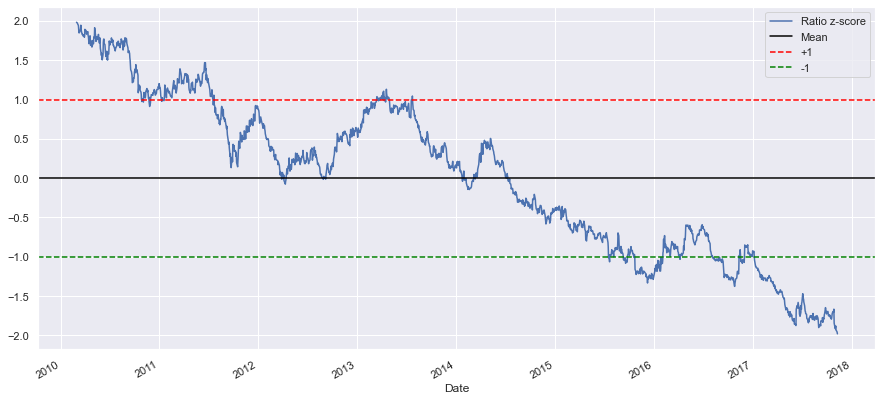

In [64]:
#calc z_score
ratios = close_raw['2010-3-1':'2017-11-08']['spy'] / close_raw['2010-3-1':'2017-11-08']['qqq']
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

In [65]:
# Compute rolling mean and rolling standard deviation
def calc_zscore(ratios, window1, window2):
    ma1 = ratios.rolling(window=window1,center=False).mean()
    ma2 = ratios.rolling(window=window2,center=False).mean()
    std = ratios.rolling(window=window2,center=False).std()
    zscore = (ma1 - ma2)/std
    return zscore

def plot_explain(S1, S2, window1, window2, zscore_60_5, gold_marker_gain, gold_marker_loss):
    ratio = S1 / S2
    # Plot price buy sell
    plt.figure(figsize=(18,9))
    buy = ratio.copy()
    sell = ratio.copy()
    buy[zscore_60_5>-1] = 0
    sell[zscore_60_5<1] = 0
    # Init buyR and sellR
    S1[window2:].plot(color='b')
    S2[window2:].plot(color='c')
    buyR = 0*S1.copy()
    sellR = 0*S1.copy()
    # When buying the ratio, buy S1 and sell S2
    buyR[buy!=0] = S1[buy!=0]
    sellR[buy!=0] = S2[buy!=0]
    # When selling the ratio, sell S1 and buy S2 
    buyR[sell!=0] = S2[sell!=0]
    sellR[sell!=0] = S1[sell!=0]
    # Plot buy and sell
    buyR[window2:].plot(color='g', linestyle='None', marker='^')
    sellR[window2:].plot(color='r', linestyle='None', marker='^')
    x1,x2,y1,y2 = plt.axis()
    plt.axis( (x1, x2, min(S1.min(),S2.min()), max(S1.max(),S2.max()) ) )
    plt.legend(['spy','qqq', 'Buy Signal', 'Sell Signal'])
    plt.show()
    # plot zscore
    plt.figure(figsize=(18,7))
    zscore_60_5.plot()
    plt.axhline(0, color='black')
    plt.axhline(1.0, color='red', linestyle='--')
    plt.axhline(-1.0, color='green', linestyle='--')
    gold_marker_gain.plot(color='g', linestyle='None', marker='^')
    gold_marker_loss.plot(color='r', linestyle='None', marker='^')
    plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
    plt.show()

def trade(S1, S2, window1, window2, zthreshhold_buysell=1.0, zthreshhold_clear=0.5, doplot=False):
    maximum_S1_needed = 0
    maximum_S2_needed = 0
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    ratios = S1/S2
    zscore = calc_zscore(ratios, window1, window2)
    # Simulate trading
    money = 0
    countS1 = 0
    countS2 = 0
    gain_count = 0
    gain_amount = 0.0
    loss_count = 0
    loss_amount = 0.0
    gold_marker_gain = zscore.copy()
    gold_marker_gain[:] = float('nan')
    gold_marker_loss = zscore.copy()
    gold_marker_loss[:] = float('nan')
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > zthreshhold_buysell:
            tmp = S1[i] - S2[i] * ratios[i]
            money += tmp
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -zthreshhold_buysell:
            tmp = S2[i] * ratios[i] - S1[i]
            money += tmp
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < zthreshhold_clear:
            tmp = countS1*S1[i] + S2[i] * countS2
            if maximum_S1_needed < countS1:
                maximum_S1_needed = countS1
            if maximum_S2_needed < countS2:
                maximum_S2_needed = countS2
            if tmp > 0:
                gain_count += 1
                gain_amount += tmp
                gold_marker_gain[i] = zscore[i]
            elif tmp < 0:
                loss_count += 1
                loss_amount += tmp
                gold_marker_loss[i] = zscore[i]
            money += tmp
            countS1 = 0
            countS2 = 0
    tmp = countS1*S1[i] + S2[i] * countS2
    if tmp > 0:
        gain_count += 1
        gain_amount += tmp
    else:
        loss_count += 1
        loss_amount += tmp
    money += tmp
    # plot
    if doplot:
        plot_explain(S1, S2, window1, window2, zscore, gold_marker_gain, gold_marker_loss)
    print(countS1)
    print(countS2)
    print(gain_count)
    print(loss_count)
    print(gain_amount)
    print(loss_amount)
    print("maximum_S1_needed: %f" % maximum_S1_needed)
    print("maximum_S2_needed: %f" % maximum_S2_needed)
    print("Money that is gained addtionally from buy/sell: %f" % money)
    return money

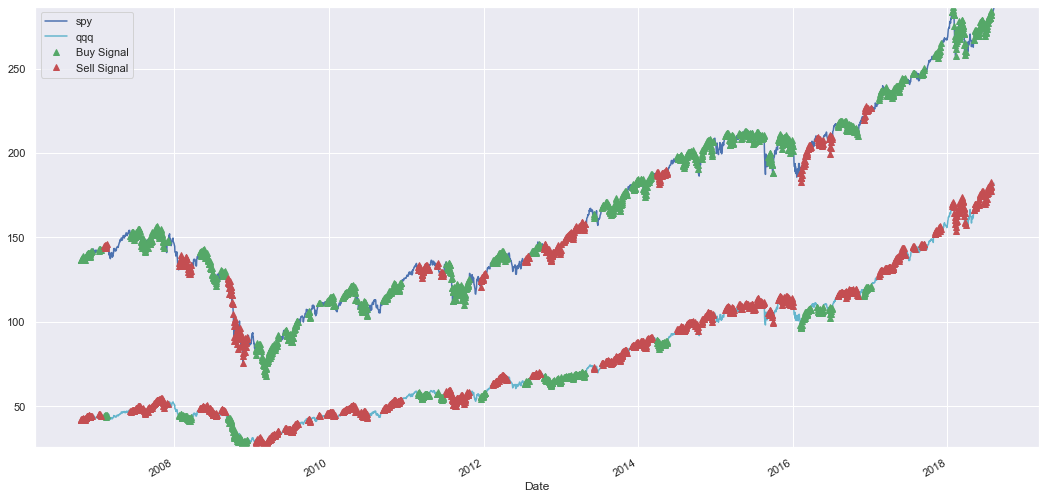

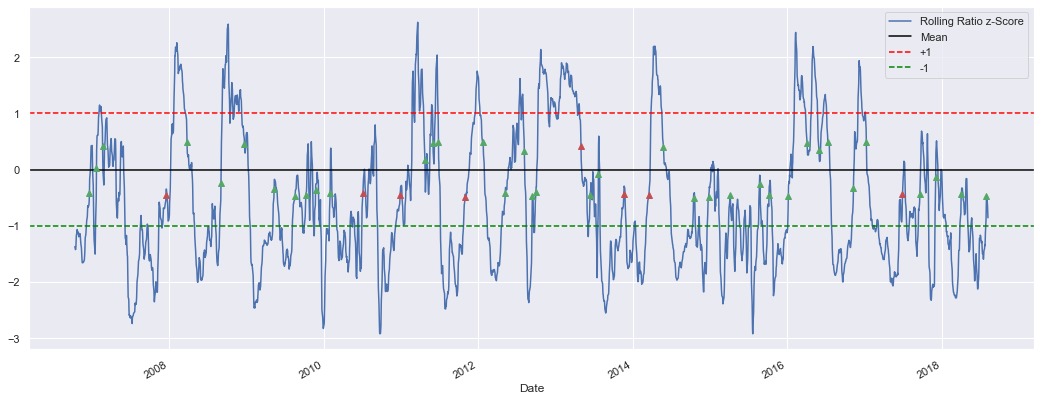

0
0
37
9
2091.236350810303
-957.0771083776972
maximum_S1_needed: 107.000000
maximum_S2_needed: 257.801261
Money that is gained addtionally from buy/sell: 1134.159242


1134.1592424326059

In [66]:
# extra money earned from pair trading 
trade(train_spy , train_qqq, 5, 90, zthreshhold_buysell=1.0, doplot=True)

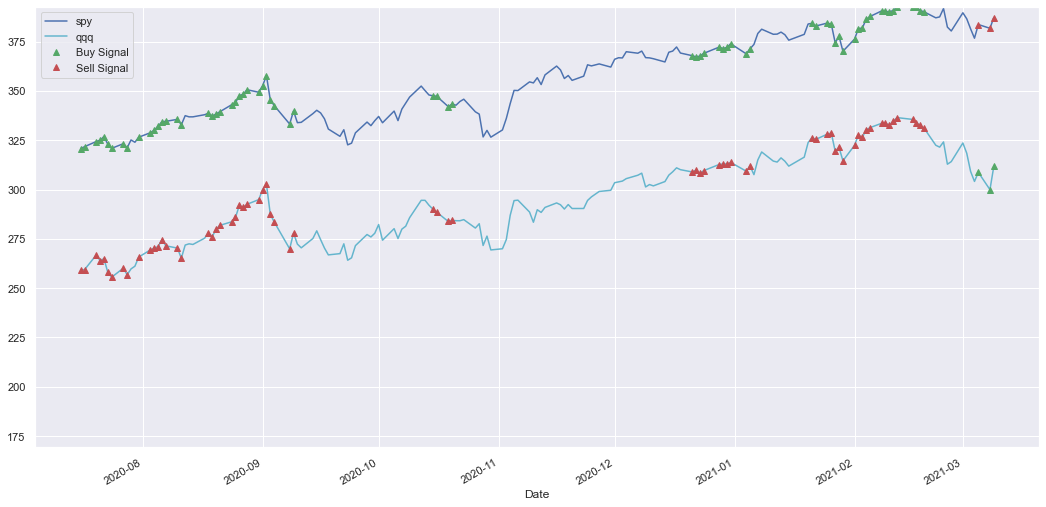

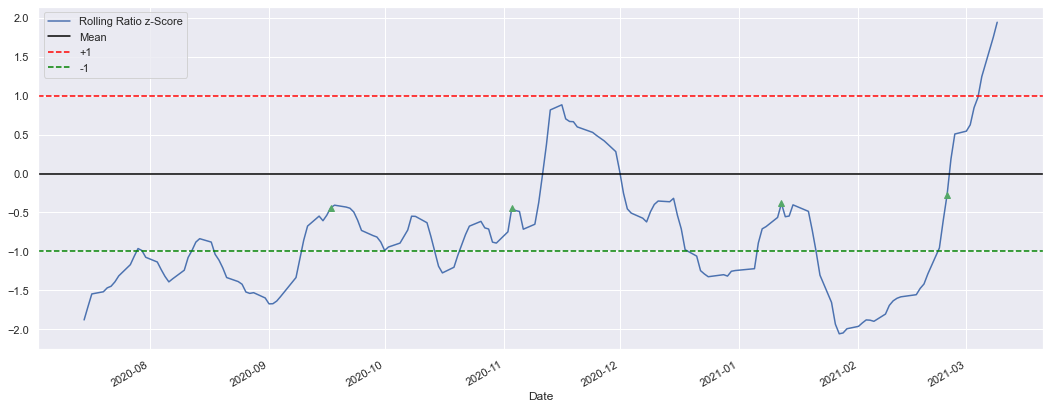

-3
3.757307692600934
5
0
537.858533994741
0.0
maximum_S1_needed: 34.000000
maximum_S2_needed: 0.000000
Money that is gained addtionally from buy/sell: 537.858534


537.8585339947413

In [67]:
## extra money earned from pair trading 
trade(test_spy , test_qqq, 5, 90, zthreshhold_buysell=1.0, zthreshhold_clear=0.5 ,  doplot=True)

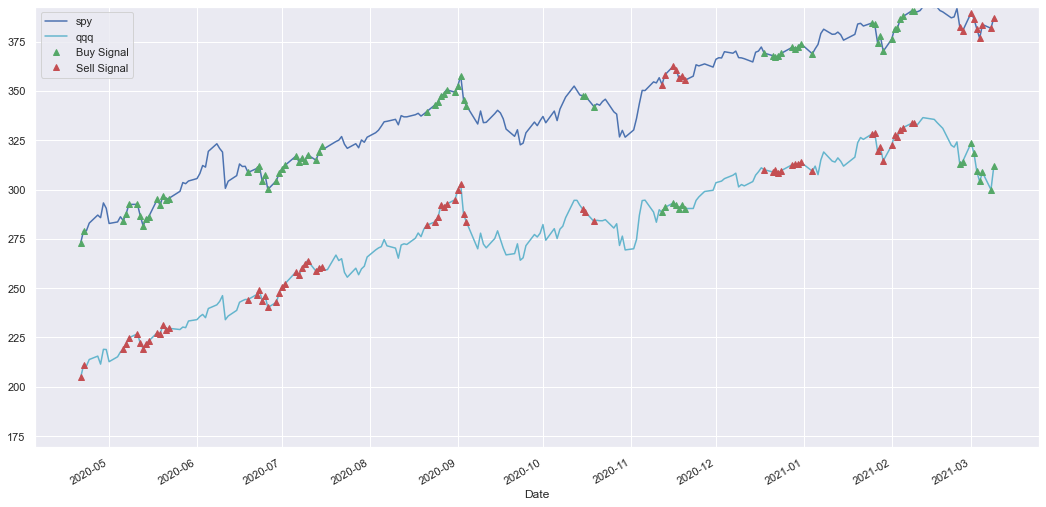

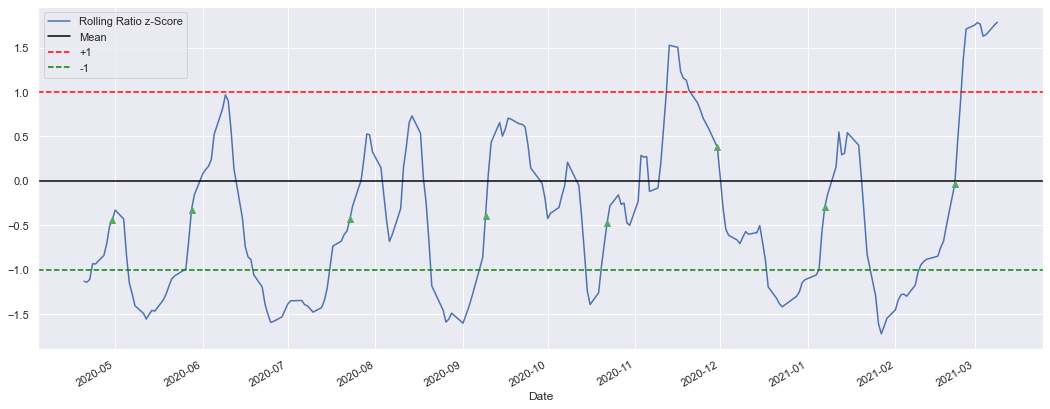

-9
11.08067659499248
8
1
448.57958499910046
-29.90770056475276
maximum_S1_needed: 18.000000
maximum_S2_needed: 8.601498
Money that is gained addtionally from buy/sell: 418.671884


418.67188443434776

In [68]:
# extra money earned from pair trading 
trade(test_spy , test_qqq, 5, 30, zthreshhold_buysell=1.0, zthreshhold_clear=0.5,  doplot=True)